In [51]:
from cv2 import imread, resize, INTER_AREA
import matplotlib.pyplot as plt
from numpy import concatenate, array

In [52]:
# Global Variables
bits_img_count = 4 # Number of bits for storing the number of images count
bits_resolutions = [12,12,2] # Number of bits for storing the resolution of the image (height, width, channels)
bits_pixel = 8 # Number of bits for storing the pixel value of our image
"""
Logic for the encoding of array with binary data
f : Frame Pixel
i : Image Binary
e : Encoded Output
f i | e
0 0 | 0
0 1 | 1
1 0 | 0
1 1 | 1

Code logic for encode
1. Right shift by the number of bits
2. Left shift by the same number of bits
3. OR operation with the Image Binary Bits

Code logic for decode
1. AND operation with the required number of bits
2. Merge all bits together
3. Separate according to the meta-data obtained
"""

'\nLogic for the encoding of array with binary data\nf : Frame Pixel\ni : Image Binary\ne : Encoded Output\nf i | e\n0 0 | 0\n0 1 | 1\n1 0 | 0\n1 1 | 1\n\nCode logic for encode\n1. Right shift by the number of bits\n2. Left shift by the same number of bits\n3. OR operation with the Image Binary Bits\n\nCode logic for decode\n1. AND operation with the required number of bits\n2. Merge all bits together\n3. Separate according to the meta-data obtained\n'

In [53]:
def check_frame_shape(shape):
    if(len(shape) == 3):
        return shape
    elif(len(shape) == 2):
        return (shape[0],shape[1],1)
    else:
        raise ValueError("Shape not identified")
    
def flatten(frame_list):
    return concatenate([frame.flatten() for frame in frame_list],axis=0)

def fill_zeros(binary_val, length):
    if(len(binary_val)<length):
        return "0"*(length-len(binary_val))+binary_val
    elif(len(binary_val)==length):
        return binary_val
    else:
        raise ValueError("Length requested less than the Binary Length")


def binary_conversion(meta_data_list, data_list):
    res = ""
    count = meta_data_list[0]
    res += fill_zeros(bin(count)[2:],bits_img_count)
    i = 1
    while(i <= count):
        res += fill_zeros(bin(meta_data_list[i][0])[2:], bits_resolutions[0])
        res += fill_zeros(bin(meta_data_list[i][1])[2:], bits_resolutions[1])
        res += fill_zeros(bin(meta_data_list[i][2])[2:], bits_resolutions[2])
        i += 1
    for data in data_list:
        res += fill_zeros(bin(data)[2:], bits_pixel)
    return res

def binary_inversion(binary_string):
    count = int(binary_string[0:bits_img_count], 2)
    resolutions = []
    i = bits_img_count
    while(i <= count*sum(bits_resolutions)):
        resolutions.append(
            (int(binary_string[i:i+bits_resolutions[0]], 2),
             int(binary_string[i+bits_resolutions[0]:i+bits_resolutions[0]+bits_resolutions[1]], 2),
             int(binary_string[i+bits_resolutions[0]+bits_resolutions[1]:i+bits_resolutions[0]+bits_resolutions[1]+bits_resolutions[2]], 2)))
        i += sum(bits_resolutions)
    meta_data_list = [count] + resolutions
    limit = sum([a[0]*a[1]*a[2] for a in resolutions])*bits_pixel+sum(bits_resolutions)
    
    # i -= sum(bits_resolutions)
    data_list = []
    for j in range(i, limit, bits_pixel):
        data_list.append(int(binary_string[j:j+bits_pixel],2))

    return meta_data_list, data_list
        

def embed(arr, binary_string, bits):
    chunks = [binary_string[i:i+bits] for i in range(0, len(binary_string), bits)]
    for i,chunk in enumerate(chunks):
        arr[i] = ((arr[i]>>bits)<<bits) | int(chunk, 2)
    return arr

def extract(arr, bits):
    res = ""
    for val in arr.tolist():
        res += fill_zeros(bin(val&((2**bits)-1))[2:],bits)
    return res

In [54]:
def encode(frame_list, image_list, bits = 1):
    # Initialization of input frames
    frame_count = len(frame_list)
    frame_shape = check_frame_shape(frame_list[0].shape)
    pixel_arr = flatten(frame_list)

    # Get the parameters for the global variables | Number of Images | Resolutions of Each Image
    meta_data_list = [len(image_list)]+[check_frame_shape(image.shape) for image in image_list]

    # Convert the images to be encoded into a list of binary values
    data_list = flatten(image_list)

    binary_string = binary_conversion(meta_data_list, data_list)
    
    # Embed the binary
    pixel_arr = embed(pixel_arr, binary_string, bits)


    # Reconstruct the input frames
    frame_list = []
    total_pixel = frame_shape[0]*frame_shape[1]*frame_shape[2]
    for i in range(0,frame_count):
        frame_list.append(pixel_arr[i*total_pixel:(i+1)*total_pixel].reshape(frame_shape))
    return frame_list

In [55]:
def decode(frame_list, bits = 1):
    # Initialization of the input frame
    pixel_arr = flatten(frame_list)

    # Extract all the values needed from the pixel array
    binary_string = extract(pixel_arr, bits)
    meta_data_list, data_list = binary_inversion(binary_string)
    
    # Form the image list from the meta-data
    image_list = []
    image_count = meta_data_list[0]
    i = 1
    while(i <= image_count):
        resolution_shape = meta_data_list[i]
        resolution_product = resolution_shape[0]*resolution_shape[1]*resolution_shape[2] # type: ignore
        image_arr = array(data_list[0:resolution_product])
        data_list = data_list[resolution_product:]
        image_list.append(image_arr.reshape(resolution_shape))
        i = i+1
    return image_list
    

(-0.5, 511.5, 511.5, -0.5)

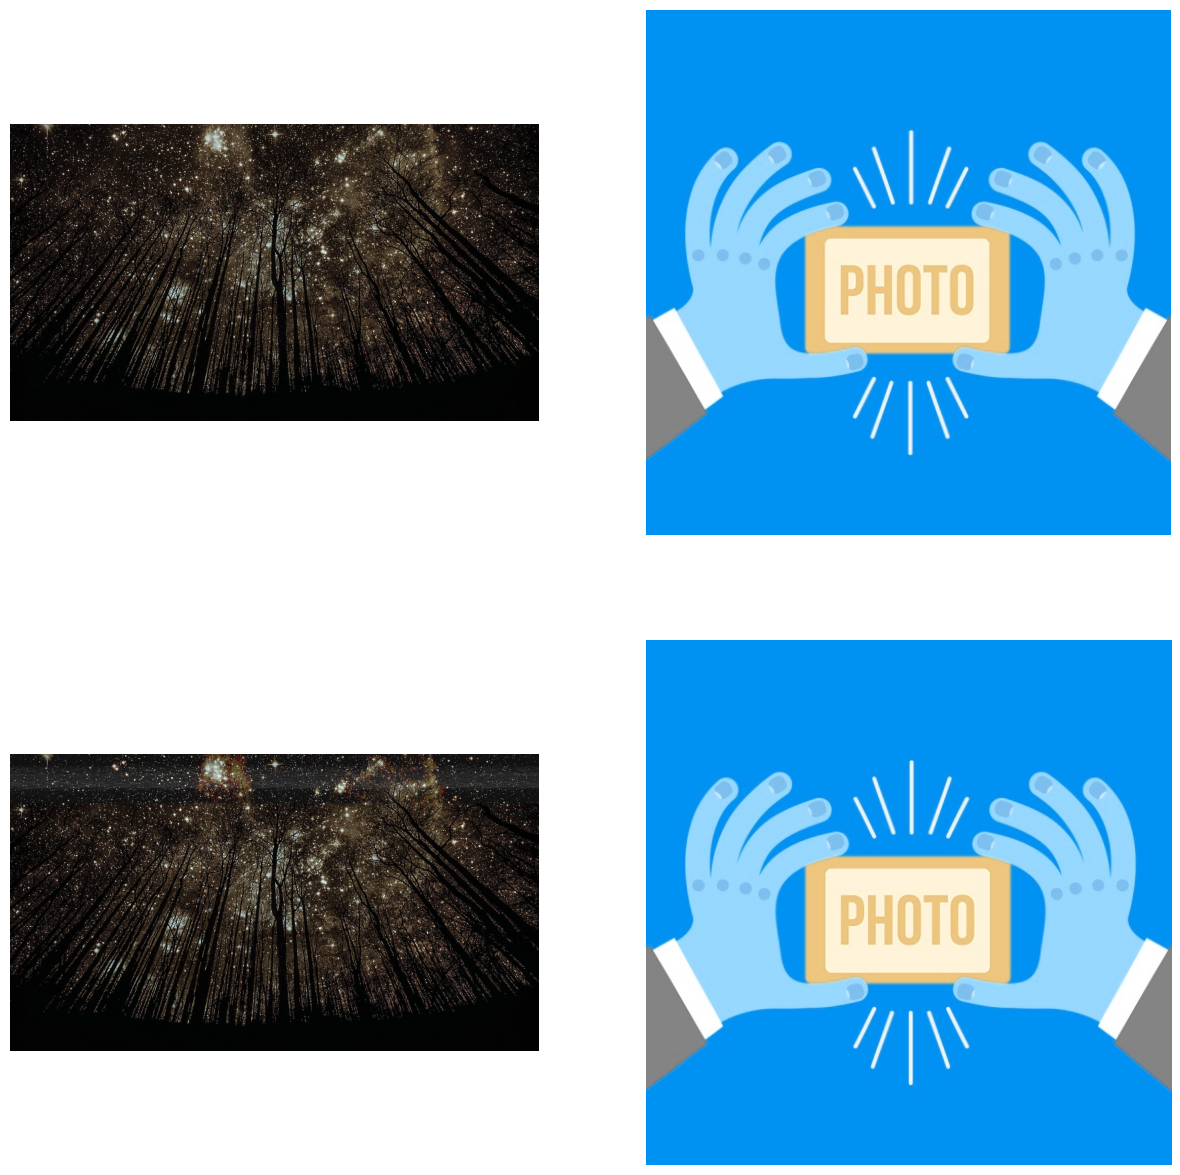

In [61]:
input_image = imread("high_res.jpg")
encode_image = imread("small_img.jpg")

output_image = encode([input_image], [encode_image], 6)[0]
decode_image = decode([output_image], 6)[0]
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(input_image)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(encode_image)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(output_image)
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(decode_image)
plt.axis('off')

In [60]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL  import Image
import matplotlib.image as plt_img
import imageio as iio
import cv2
import skvideo.io

video = cv2.VideoCapture("videos/vid.mp4")
frames = []
frame_rate = video.get(cv2.CAP_PROP_FPS)

while True:
    ret, frame = video.read()
    if ret:
        frames.append(frame[:,:,::-1])
    else:
        break


bytes = iio.v3.imwrite("<bytes>", np.array(frames),format = 'GIF', fps = frame_rate)
main_frames = np.array(frames)

C:\Users\sayan\AppData\Roaming\Python\Python310\site-packages\imageio\plugins\pillow.py:98: UserWarning: Can't determine file format to write as. You _must_ set `format` during write or the call will fail. Use `extension` to supress this warning. 
  warnings.warn(


In [29]:
imageio_frames = np.array(iio.mimread("videos/giphy.gif"))[:,:,:,0:3]
print(imageio_frames.shape)
np.array_equal(imageio_frames, main_frames)

(98, 240, 320, 3)


False

In [27]:
def split_animated_gif(gif_file_path):
    ret = []
    gif = Image.open(gif_file_path)
    for frame_index in range(gif.n_frames):
        gif.seek(frame_index)
        frame_rgba = gif.convert("RGB")
        ret.append(np.array(frame_rgba))
    return ret

image_frames = np.array(split_animated_gif("videos/giphy.gif"))
image_frames[0,:,:,0]

array([[185, 185, 185, ..., 208, 208, 208],
       [186, 186, 185, ..., 208, 208, 208],
       [189, 189, 185, ..., 208, 208, 208],
       ...,
       [ 92,  92,  92, ..., 118, 126, 126],
       [ 76,  76,  91, ..., 126, 126, 126],
       [ 71,  76,  76, ..., 126, 126, 126]], dtype=uint8)

In [30]:
imageio_frames[0,:,:,0]

array([[185, 185, 185, ..., 208, 208, 208],
       [186, 186, 185, ..., 208, 208, 208],
       [189, 189, 185, ..., 208, 208, 208],
       ...,
       [ 92,  92,  92, ..., 118, 126, 126],
       [ 76,  76,  91, ..., 126, 126, 126],
       [ 71,  76,  76, ..., 126, 126, 126]], dtype=uint8)

In [36]:
main_frames[0,:,:,0]

array([[185, 186, 187, ..., 198, 198, 198],
       [189, 189, 187, ..., 198, 198, 198],
       [188, 188, 186, ..., 201, 201, 201],
       ...,
       [ 86,  87,  90, ..., 119, 120, 121],
       [ 78,  80,  84, ..., 120, 121, 121],
       [ 76,  78,  83, ..., 120, 120, 120]], dtype=uint8)

In [11]:
file = open("videos/giphy.gif", "wb")
file.write(bytes)
file.close()

In [18]:
from PIL import Image
import imageio as iio
import numpy as np
import io

for _ in range(100):
    expected_frames = main_frames

    # # test writing with pillow
    # pil_buffer = io.BytesIO()
    # im = Image.fromarray(expected_frames[0])
    # gif_bytes = im.save(pil_buffer, format="GIF")
    # actual_pil = iio.v3.imread(pil_buffer, mode="L")
    # assert np.all(actual_pil == expected_frames[0])

    # test writing with ImageIO
    gif_bytes = iio.v3.imwrite("<bytes>", expected_frames, format="GIF") 
    actual_iio = iio.v3.imread(gif_bytes, index=None)
    print(expected_frames.shape, actual_iio.shape)
    assert np.array_equal(actual_iio,expected_frames)

print("No roundtrip modified any pixels.")

C:\Users\sayan\AppData\Roaming\Python\Python310\site-packages\imageio\plugins\pillow.py:98: UserWarning: Can't determine file format to write as. You _must_ set `format` during write or the call will fail. Use `extension` to supress this warning. 
  warnings.warn(


(98, 240, 320, 3) (98, 240, 320, 3)


AssertionError: 

In [38]:
def process_image(main_frames):
    
    new = []
    for frame in main_frames:
        new_frame = Image.fromarray(frame)
        assert np.all(np.array(new_frame) == frame)
        # new_frame = new_frame.convert(mode = "RGB")
        assert np.all(np.array(new_frame) == frame)
        new.append(new_frame)
    new[0].save('videos/giphy.gif', append_images = new[1:], duration = 2, loop = 0x0, format = 'GIF', optimize = False, save_all = True)

process_image(main_frames)

In [93]:
shape = main_frames.shape
change = np.random.randint(-2,2,shape)
# change = np.zeros(shape)
temp_frames = (main_frames+change).astype(np.uint8)

video = cv2.VideoWriter("videos/video.avi", cv2.VideoWriter_fourcc(*'RGBA'), frame_rate, (temp_frames[0].shape[1],temp_frames[0].shape[0]))
for frame in temp_frames:
    video.write(frame[:,:,::-1])
video.release()

new_frames = []
video = cv2.VideoCapture("videos/video.avi")
while True:
    ret, frame = video.read()
    if ret:
        new_frames.append(frame[:,:,::-1])
    else:
        break
np.array_equal(temp_frames, np.array(new_frames))

True

In [94]:
file.close()